# Direct spectrum estimation of speech signal

## Load packages and functions

In [1]:
using ForneyLab       # based on last official release
using LinearAlgebra
using Plots
using PyPlot
using ProgressMeter
using Compat
using WAV
using Base64
using FileIO
using HDF5
using FLAC
using DSP
using LAR
using LAR.Node
using FFTW

include("../functions/auxiliary/buffer.jl")
include("../functions/auxiliary/audioplayer.jl")
include("../functions/auxiliary/workflow.jl")
include("../functions/auxiliary/fourier.jl")
include("../functions/auxiliary/warpedfilter.jl")
;

## Adjustable parameters

In [2]:
# signal preprocessing
sound_file = "../data/woman.wav"      # specify sound location
fs_desired = 8000                        # specify desired sampling frequency

# inference and modelling
AR_order = 10                            # order of auto-regressive model
iterations = 3                           # number of iterations for variational message passing
Λ_meas = 1e-10                            # assumed precision of measurement noise
;

## Load data

In [3]:
# load and process speech signal
x_time, fs_time = wavread(sound_file, format="native")
fs_time = Int(fs_time)
x_time = x_time[2*fs_time+1:5*fs_time]
x_time = resample(x_time, fs_desired/fs_time)
x_time = 100*x_time/var(x_time)

# specify time axis
t = collect((1:length(x_time))/fs_desired)

# create audioplayer
audioplayers(x_time, fs=fs_desired)
;

<source src="data:audio/wav;base64,UklGRjx3AQBXQVZFZm10ICgAAAD+/wEAQB8AAAB9AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YQB3AQAwqTe7XRCwO9Q2bzwppuc7oYC+uwo4yrtuw8e7TCLgPGMV8ryo+3y7u/Lpu6yiLjohO7s8KjrIvPzJFbqVj4y8oznoPHgJ4jz+AkG80OlkvUWKg7st2kY9WsS6vCPsTLyCGCG8u5hwO9AYXD2zjSW9NrUwvP7STrxU+xo94DEJvFRzE704KAQ9votUvfSVuDy5xw+7C0ORvAXmd7xLok66sx5uPQNfX7wu7HO9tTsAPCVIeD1Pz8S82r6LvTXyMTznyAo9jFuZO0TlMb365we9/3kdPSDFLzz67cO8oUeFvO/2ZryIrDM949KnvNyvLr0OGY68cF1aPVcEwbvANJK9RsTaOwn8CD1LT8w7rjNcvTDSvDwPsHW8VNMovEP0U7zydGi8Z12/vBx2LLxtbds8pneyumCblLyg+Y+8dh4DPQ/j/jpgCps8XyZ4vcmqOjzqSX08+F2OvEXOQbvv2S66RfzcuxX7B7z6iKA7RzO/vNXtnTvGWZE8sxbPu7bsQzuJhVq9QJFrvKKZKD2xrAK9XQnIu0sXf7zw/U48qjnNujcvfrtQkA26G3jLu6wQszyKN2u8CSBTPOLe97hN/0E7SzkivemYDL0gj848oNATPD1g07yYi8E7aDyhvJtYHT07dVq8FzjcvAHxEz24uXe8gh0BPXILcr0kZBU9e5giPKHYM724rmu89EJZu3byNz1jbiq9OQqnu3AmN7zG7988/L5zPFoZPb0gmq070guSOw3+hDxZcLK8XvUKvDP+kbwtwUc9l+HpvEkmsrzIDKa8IbfNPEZKmTvNtQ+94NX3vEtsgDwdFEE9FGTkvCkDT7wim6e8Wg4wPAjVtzyGw3W8rky7vGYQ7DxjE9G8OEWtO2TLSDo2Z9O7iv2MPASPjjuLGa28eAKgPE2fczva4BY6rSUTvXsQpDxGA/Q8ddzaOjGdubzQ2tI7h80mvGURF7x4Sgs9MUBMuyZgrbxstQK8E5eJOwbRjrt6hMu73AZLO20qCT0h78W8lO9HvNXQsLsjHRo9vuEpvHdLLLxSuJy59LgaPBJVqry8msC8DLW7PEjIoDwLnpC80flSPP4plzt6L4u4NcQ2PCJ3OL2RUeY8K/QKvHHVRjwX0yk8LH+JOkSQDj1Waii8Uo/6uZTckDu0sP67PtEavO6sHzxy+rI8VYiEvNeZazzC0Le65RLHvAjwiTym61w8aT9VPMJIxbp2GHg71jyzO3V3JLzRs0I8klclvKPZ9Tu2lws9b8hTvItKDL2ahgs8YgaBux8MhruHSJ87hXL/vEeZpDwpueE8Z1cgvUDg5jsy2648dg0qvDTDNbzgF6E7DYfhPHIyHb1cgvy7ciu9vOhBPTxyDkk7CepxvN92izzGoCe4x7Jzu6HC+rxEUQ08V1d6PD7XtbzZP/m8XK1LO7E0VD1wpcG8gV8XvF3Z8rscszY8Qs1YvBk1JLx1uyQ8Q29eOqXuprzdnQS84a6iPBdJTbt5Pga8E1lhvFkQnjxBbkY8S30yvcg/JT0a6xi9lGkwvFc/HDxVo6w8GswavJIm7Tvlezu8b6e7PMv8KryaNlO9hiDYO6ZxwzwztHY8R/9cvTnP3DyxEys6/WIrPTydKr2riZe8X6+LPEH0Cz1AzJ+8LatZvXcLMzwr65U8pbzAPEjrCr3b+7q84frbOgkArTxo8xM8H+jlvAYNFbuREaU77RbuPEmRw7zLosG7406kPBDaszzu52q8I2AOvT/GM7yY5ue8qRsfPfqEtLyMB/G7gPuKPNxYvLuwIIm7syKzvNoV+7sKAB49C2fhupQhqruVEng8fu+wvIgLwTw6X368ingWOw/anrmT46I8QysAvbIKjrw8boQ8sxnVPL0gbDvBuA+9YUBbOnwqLj2ScuS8cif/OiYvRLs5hko85BevPMHAKjwUotq8G8RzvDDt2TxrLQ89CLBZvJPHvjvlolA7fI+QvOT9jzsEuiA8mraXu/m2LbxZpSI9X8WyPGRY87xHiS47acWFu3ZslTw3pRk7PD/+u0wvYztulJE849b3PFIKdb0gkgG8RbJmPb781brDPgu9OUy2O1xA4DtYybk86Cn2Ox/Pmrw8uri7UdlBPRSUWTwAob+8PB2Eu5fcPjxDb9M8TxtWO9JpBb260KS8iI2KPUSb8DtQv4u9ty9ZPDtbzDypSNM8pt+WPLvsBL0wvYY7eaEIPbq4I7tuBTG9YjaRvDgzlj0/K7q7go8hvQejLzxZRPI8GfOUOynQqjtos9e7frryunCN8jrRcQs8CVG9vC3iyjsQQcQ8+gLku/CjW7uln2O7fgqhPAgWkbyLL+w77YuBOvpPV7xEhnU8KCwIPA/C6rt9pfU7ki9yOzgim7wRHZU8cOELPMBZWTw185680lLLPEbAoDu5puu8/U69POSfejyu+cy88Y8fvIWvwTyC5IM8812PvJAiALwDxgs9DZ7xO71rqjpMD6q8pwOAvID58DwXQ4c65ctYPIXJOr0uho48+4v3u7MfGTz0Vo68TZtGPIDzlbzt8hY7RDehPC3EyjxhmdS8E3SmvDqpJbvJ4KY8G57UO2zWSLwhokG85EmBPCIkkDxSXwM7HMzLPCjSBrxO6DS9ZqUHPL39kDsJuhO8j2rqu65mWzyAHQc9W5egvLvJwTzuc907+X6ivFDpdzwpvoi8AprOvM4NCD17I4c7fbJhu7l4lrt9JxU9HwkGvXt7lLyyuI08uXQYPSd/pTueUJe86siPO+MlrDxdRAK9f1wDO7N3cDtK8H08E88HvUP6Y7vDMg49u4Y9vDiJjLxRe6e8e0RrPWNwIjywAAa9zR7ivHlWBz0HBos8aTcvvOcumbxTzok8j5OgPKZtPTxVmP28mkuUvPklIjviLzW5N2IkPN0Q+zzAX6u8C6LWPIUUrLpq2Ca9/3HJPFlZI73lfmc8VPtyPIfIVTz/JIw8DGnwvAn24Lt7lG488Gf/uwfvNjv79AQ822QEvL/yY70IQgO8gMfUPGlgsjwj8Za91sVhPfkG7jwiaUe8OwixvIAR7ToOlg09g2gavUQ7sbrqJMM7l8z+O6Y3Ujxhtha9tDFlO0Ti+zzROuO7GFmDvA0BdDzufto5R18ovMZaOTpnwGw8MkkXvZAK2zsLo5Y7Z/nouprZ8zxfccy7ZXZQvBgQ9byw9688UPqSu6irNL07dZY8MWxdusuT1buqLB28aGYBPaz/Z7xBkIO81BcuPNVTALx9XkM9JW09vYuUsbyRm6K6UBW4POPEF72g9Bq8c70EPc5YlruK3Je8JRq1OhSsq7xxyhS8K1FIuoA2+rqgQ3O7jTFevNcgrjw4eC28EASnO36f17p9VPG8oxCcPL/pYTwGvy29J1r2O+LvhLx5kvI8aKEEvf4gxLu7YMk7uixbvLzH0Dz6S0M8qSwhvQvEHTzkvF478EMlPHITjTw5MBC98xVLO3tmxbsuaqq7M4grPPhhMj2rvUi9bN+SvNaUnjw24846/FxlvCh2KDyBJrS8YuNePMq9Oz2nDyi9kOAHvOPcq7ub0O48u2gBvXUIMzuHiDs8ZaLguzfaGb3Dikk9p4mRvIF46Lya+Wc7C4qgvH3IrDxAx6274LXRvPv7AT0Vd5m8DCi2vIo5HbzMzbs7Z3YovTo/pTpkZ228+g0wPHGAAjy4XRg8vWh0vGfAL72mvxg8t64hPGACIrwA2/M7VOGFPBTDJ7tkNoC70cqFvFXFmbyLlJ46xXr3vL6bGj1CkFy8VofNvJxZlLvqpqs8dqfEu5oWPr0D74I8HxyuPDBTibcmhi28DDhNPOxG3LxAiGs8mGURvKzlIr0YhMA7ZLwwu91SLj1juAy9TXvhvBZU+DwtxLE8wwj2vLlsNDxzM

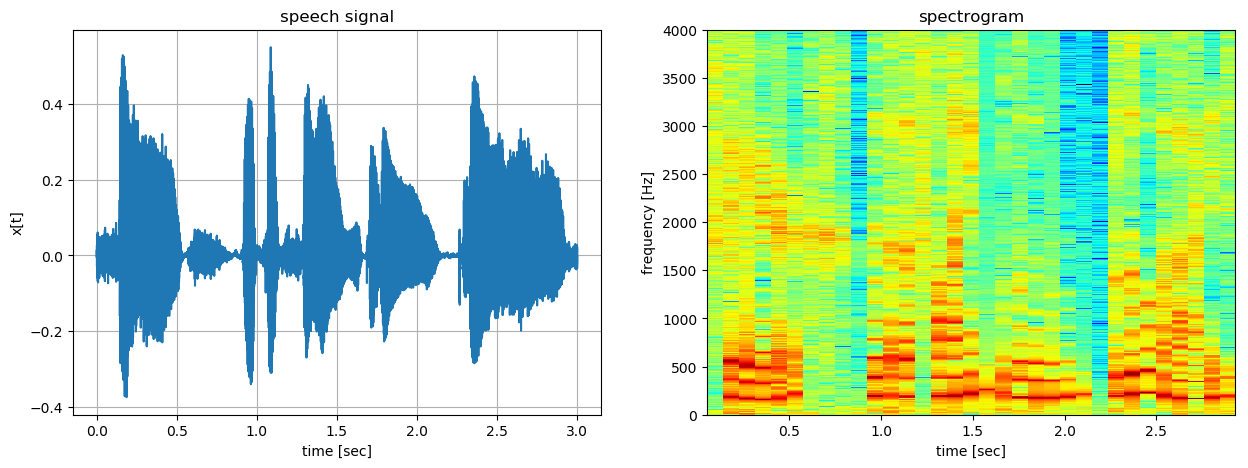

In [4]:
# create figure with subplots
_, ax = plt.subplots(ncols=2, figsize=(15,5))

# plot speech signal as a function of time
ax[1].plot(t, x_time)

# plot spectrogram of speech signal
plot_spectrogram(spectrogram(x_time, convert(Int, 100e-3*fs_desired), convert(Int, 10e-3*fs_desired), fs=fs_desired), fs_desired, ax=ax[2])

# visual modifications
ax[1].grid(), ax[1].set_ylabel("x[t]"), ax[1].set_xlabel("time [sec]"), ax[1].set_title("speech signal"), ax[2].set_title("spectrogram")
;

## Generative model

In [5]:
# create factor graphs
fg = FactorGraph()

# AR node
@RV γ ~ ForneyLab.Gamma(placeholder(:a_γ), placeholder(:b_γ))
@RV θ ~ GaussianMeanPrecision(placeholder(:μ_θ, dims=(AR_order,)), placeholder(:Λ_θ, dims=(AR_order, AR_order)))
@RV Sprev ~ GaussianMeanPrecision(placeholder(:μ_Sprev, dims=(AR_order,)), placeholder(:Λ_Sprev, dims=(AR_order, AR_order)))
@RV S ~ LAR.Autoregressive(θ, Sprev, γ)

# selection and input
d = zeros(AR_order)
d[1] = 1
@RV x_AR ~ DotProduct(d, S)

# Gaussian mixture node
@RV p ~ ForneyLab.Beta(placeholder(:a_p),placeholder(:b_p))
@RV z ~ ForneyLab.Bernoulli(p)
@RV γn ~ ForneyLab.Gamma(placeholder(:a_γn), placeholder(:b_γn))
@RV n ~ GaussianMeanPrecision(0, 1e10)
@RV γAR ~ ForneyLab.Gamma(1e10, 1e5)
@RV x ~ GaussianMixture(z, x_AR, γAR, n, γn)

@RV y ~ GaussianMeanPrecision(x, Λ_meas)
placeholder(y, :y)

ForneyLab.draw(fg)
ForneyLab.draw(fg, external_viewer=:default)
;

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.38.0 (20140413.2041)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 11925575170278938549 -->
 11925575170278938549 
 
 placeholder_b_p 
 
<!-- 6963895180989561015 -->
 6963895180989561015 
 
 placeholder_Λ_θ 
 
<!-- 18414909250130955013 -->
 18414909250130955013 
 
 placeholder_b_γ 
 
<!-- 12330968017469070200 -->
 12330968017469070200 
 
 placeholder_a_p 
 
<!-- 4806765819225006500 -->
 4806765819225006500 
 
 placeholder_μ_Sprev 
 
<!-- 13274717385290353930 -->
 13274717385290353930 
 
 Gam 
 gamma_2 
 
<!-- 15298388233158628633 -->
 15298388233158628633 
 
 placeholder_b_γn 
 
<!-- 13274717385290353930--15298388233158628633 -->
 13274717385290353930--15298388233158628633 
 
 b_γn 
 1 out 
 3 b 
 
<!-- 5649425823013247866 -->
 5649425823013247866 
 
 placeholder_a_γn 
 
<!-- 13274717385290353930--5649425823013247866 -->
 13274717385290353930--5649425823013247866 
 
 a_γn 
 1 out 
 2 a 
 
<!-- 4150475501522271274 -->
 4150475501522271274 
 
 𝒩 
 gaussianmeanprecision_1 
 
<!-- 4150475501522271274--6963895180989561015 -->
 4150475501522271274--6963895180989561015 
 
 Λ_θ 
 1 out 
 3 w 
 
<!-- 10116060664183247990 -->
 10116060664183247990 
 
 placeholder_μ_θ 
 
<!-- 4150475501522271274--10116060664183247990 -->
 4150475501522271274--10116060664183247990 
 
 μ_θ 
 1 out 
 2 m 
 
<!-- 14666395282568721309 -->
 14666395282568721309 
 
 clamp_3 
 
<!-- 9343379256166097283 -->
 9343379256166097283 
 
 placeholder_y 
 
<!-- 3304880813327145446 -->
 3304880813327145446 
 
 𝒩 
 gaussianmeanprecision_4 
 
<!-- 9343379256166097283--3304880813327145446 -->
 9343379256166097283--3304880813327145446 
 
 y 
 1 out 
 1 out 
 
<!-- 10313454318362561537 -->
 10313454318362561537 
 
 Gam 
 gamma_3 
 
<!-- 5575684056714548971 -->
 5575684056714548971 
 
 clamp_4 
 
<!-- 10313454318362561537--5575684056714548971 -->
 10313454318362561537--5575684056714548971 
 
 clamp_4 
 1 out 
 2 a 
 
<!-- 4895132175367929338 -->
 4895132175367929338 
 
 clamp_5 
 
<!-- 10313454318362561537--4895132175367929338 -->
 10313454318362561537--4895132175367929338 
 
 clamp_5 
 1 out 
 3 b 
 
<!-- 14343025310956640577 -->
 14343025310956640577 
 
 𝒩 
 gaussianmeanprecision_2 
 
<!-- 14343025310956640577--4806765819225006500 -->
 14343025310956640577--4806765819225006500 
 
 μ_Sprev 
 1 out 
 2 m 
 
<!-- 3118677077919452448 -->
 3118677077919452448 
 
 placeholder_Λ_Sprev 
 
<!-- 14343025310956640577--3118677077919452448 -->
 14343025310956640577--3118677077919452448 
 
 Λ_Sprev 
 1 out 
 3 w 
 
<!-- 18134700311381419270 -->
 18134700311381419270 
 
 dot 
 dotproduct_1 
 
<!-- 13805636107803210701 -->
 13805636107803210701 
 
 AR 
 autoregressive_1 
 
<!-- 18134700311381419270--13805636107803210701 -->
 18134700311381419270--13805636107803210701 
 
 S 
 1 y 
 3 in2 
 
<!-- 14883053552483578699 -->
 14883053552483578699 
 
 clamp_1 
 
<!-- 18134700311381419270--14883053552483578699 -->
 18134700311381419270--14883053552483578699 
 
 clamp_1 
 1 out 
 2 in1 
 
<!-- 14905033716184560899 -->
 14905033716184560899 
 
 Beta 
 beta_1 
 
<!-- 14905033716184560899--11925575170278938549 -->
 14905033716184560899--11925575170278938549 
 
 b_p 
 1 out 
 3 b 
 
<!-- 14905033716184560899--12330968017469070200 -->
 14905033716184560899--12330968017469070200 
 
 a_p 
 1 out 
 2 a 
 
<!-- 1790086462785815407 -->
 1790086462785815407 
 
 clamp_2 
 
<!-- 1225882597993517607 -->
 1225882597993517607 
 
 Ber 
 bernoulli_1 
 
<!-- 1225882597993517607--14905033716184560899 -->
 1225882597993517607--14905033716184560899 
 
 p 
 1 out 
 2 p 
 
<!-- 17558447214559209198 -->

## Algorithm generation

In [6]:
# specify recognition factorization and create algorithm
q = RecognitionFactorization(θ, [S, Sprev], γ, z, γn, x, n, p, ids=[:θ :S :γ :z :γn :x :n :p])
algo = compatibility_fix(variationalAlgorithm(q))

# evaluate algorithm
eval(Meta.parse(algo))
println(algo)
;

begin

function stepγ!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(undef, 2))

messages[1] = ruleVBGammaOut(nothing, ProbabilityDistribution(ForneyLab.Univariate, PointMass, m=data[:a_γ]), ProbabilityDistribution(ForneyLab.Univariate, PointMass, m=data[:b_γ]))
messages[2] = ruleSVariationalARIn3PPPN(marginals[:S_Sprev], marginals[:θ], nothing)

marginals[:γ] = messages[1].dist * messages[2].dist

return marginals

end

function stepp!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(undef, 2))

messages[1] = ruleVBBetaOut(nothing, ProbabilityDistribution(ForneyLab.Univariate, PointMass, m=data[:a_p]), ProbabilityDistribution(ForneyLab.Univariate, PointMass, m=data[:b_p]))
messages[2] = ruleVBBernoulliIn1(marginals[:z], nothing)

marginals[:p] = messages[1].dist * messages[2].dist

return marginals

end

function stepγn!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(undef, 2))

messages[1] = rule

## Perform inference

In [18]:
# create memory variables
μ_θ_mem = Array{Array{Float64, 1}}(undef, length(x_time))
Λ_θ_mem = Array{Array{Float64, 2}}(undef, length(x_time))
a_γ_mem = Array{Float64}(undef, length(x_time))
b_γ_mem = Array{Float64}(undef, length(x_time))
z_mem = Array{Float64}(undef, length(x_time))
μ_x_pred = Array{Float64}(undef, length(x_time))
var_x_pred = Array{Float64}(undef, length(x_time))

# set priors
μ_θ_min = randn(AR_order)
Λ_θ_min = 1e-10 * Ic(AR_order)
μ_S_min = zeros(AR_order)
Λ_S_min = 1e-10 * Ic(AR_order)
a_γ_min = 0.001
b_γ_min = 0.001
a_p_min = 1
b_p_min = 1
a_γn_min = 0.001
b_γn_min = 0.001

# create progress bar
p = Progress(length(x_time), 1, "Observed ")

# create marginals dictionary
marginals = Dict(:θ => vague(GaussianMeanPrecision, AR_order),
                 :γ => vague(ForneyLab.Gamma),
                 :Sprev => vague(GaussianMeanPrecision, AR_order),
                 :γn => vague(ForneyLab.Gamma),
                 :z => vague(ForneyLab.Bernoulli),
                 :x => vague(GaussianMeanPrecision),
                 :γAR => ProbabilityDistribution(ForneyLab.Univariate, ForneyLab.Gamma, a=1e10, b=1e5),
                 :n => vague(ForneyLab.GaussianMeanPrecision),
                 :p => vague(ForneyLab.Beta))

# create messages array 
messages= Array{Message}(undef, 6)

# loop through samples
for k = 1:length(x_time)
    
    # update progress bar
    update!(p, k)
    
    # update data dictionary
    data = Dict(:y => x_time[k],
                :μ_θ => μ_θ_min,
                :Λ_θ => Λ_θ_min,
                :a_γ => a_γ_min,
                :b_γ => b_γ_min,
                :μ_Sprev => μ_S_min,
                :Λ_Sprev => Λ_S_min,
                :b_p => b_p_min, 
                :a_p => a_p_min,
                :a_γn => a_γn_min,
                :b_γn => b_γn_min)
    
    # get prediction
    stepS!(data, marginals, messages)
    μ_x_pred[k] = ForneyLab.unsafeMean(messages[3].dist)
    var_x_pred[k] = ForneyLab.unsafeVar(messages[3].dist)
    
    # perform variational message passing iterations
    for it = 1:iterations
        stepS!(data, marginals)
        stepθ!(data, marginals)
        stepγ!(data, marginals)
        stepz!(data, marginals)
        stepγn!(data, marginals)
        stepx!(data, marginals)
        stepn!(data, marginals)
        stepp!(data, marginals)
    end
    
    # update priors
    μ_θ_min = ForneyLab.unsafeMean(marginals[:θ])
    Λ_θ_min = ForneyLab.unsafePrecision(marginals[:θ])
    μ_S_min = ForneyLab.unsafeMean(marginals[:S])
    Λ_S_min = ForneyLab.unsafePrecision(marginals[:S])
    a_γ_min = marginals[:γ].params[:a]
    b_γ_min = marginals[:γ].params[:b]
    a_γn_min = marginals[:γn].params[:a]
    b_γn_min = marginals[:γn].params[:b]
    a_p_min = marginals[:p].params[:a]
    b_p_min = marginals[:p].params[:b]
    
    # save infered parameters
    μ_θ_mem[k] = μ_θ_min
    Λ_θ_mem[k] = Λ_θ_min
    a_γ_mem[k] = a_γ_min
    b_γ_mem[k] = b_γ_min
    z_mem[k] = marginals[:z].params[:p]
    
end

Observed 100%|██████████████████████████████████████████| Time: 0:01:30


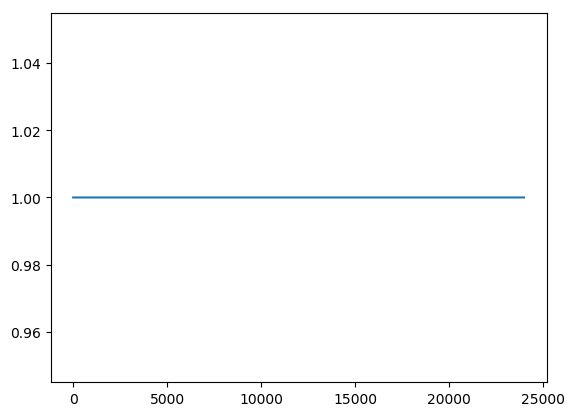

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x00000000340E9278>

In [14]:
plt.plot(z_mem)

## Predictions

<source src="data:audio/wav;base64,UklGRjx3AQBXQVZFZm10ICgAAAD+/wEAQB8AAAB9AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YQB3AQAwqTe7XRCwO9Q2bzwppuc7oYC+uwo4yrtuw8e7TCLgPGMV8ryo+3y7u/Lpu6yiLjohO7s8KjrIvPzJFbqVj4y8oznoPHgJ4jz+AkG80OlkvUWKg7st2kY9WsS6vCPsTLyCGCG8u5hwO9AYXD2zjSW9NrUwvP7STrxU+xo94DEJvFRzE704KAQ9votUvfSVuDy5xw+7C0ORvAXmd7xLok66sx5uPQNfX7wu7HO9tTsAPCVIeD1Pz8S82r6LvTXyMTznyAo9jFuZO0TlMb365we9/3kdPSDFLzz67cO8oUeFvO/2ZryIrDM949KnvNyvLr0OGY68cF1aPVcEwbvANJK9RsTaOwn8CD1LT8w7rjNcvTDSvDwPsHW8VNMovEP0U7zydGi8Z12/vBx2LLxtbds8pneyumCblLyg+Y+8dh4DPQ/j/jpgCps8XyZ4vcmqOjzqSX08+F2OvEXOQbvv2S66RfzcuxX7B7z6iKA7RzO/vNXtnTvGWZE8sxbPu7bsQzuJhVq9QJFrvKKZKD2xrAK9XQnIu0sXf7zw/U48qjnNujcvfrtQkA26G3jLu6wQszyKN2u8CSBTPOLe97hN/0E7SzkivemYDL0gj848oNATPD1g07yYi8E7aDyhvJtYHT07dVq8FzjcvAHxEz24uXe8gh0BPXILcr0kZBU9e5giPKHYM724rmu89EJZu3byNz1jbiq9OQqnu3AmN7zG7988/L5zPFoZPb0gmq070guSOw3+hDxZcLK8XvUKvDP+kbwtwUc9l+HpvEkmsrzIDKa8IbfNPEZKmTvNtQ+94NX3vEtsgDwdFEE9FGTkvCkDT7wim6e8Wg4wPAjVtzyGw3W8rky7vGYQ7DxjE9G8OEWtO2TLSDo2Z9O7iv2MPASPjjuLGa28eAKgPE2fczva4BY6rSUTvXsQpDxGA/Q8ddzaOjGdubzQ2tI7h80mvGURF7x4Sgs9MUBMuyZgrbxstQK8E5eJOwbRjrt6hMu73AZLO20qCT0h78W8lO9HvNXQsLsjHRo9vuEpvHdLLLxSuJy59LgaPBJVqry8msC8DLW7PEjIoDwLnpC80flSPP4plzt6L4u4NcQ2PCJ3OL2RUeY8K/QKvHHVRjwX0yk8LH+JOkSQDj1Waii8Uo/6uZTckDu0sP67PtEavO6sHzxy+rI8VYiEvNeZazzC0Le65RLHvAjwiTym61w8aT9VPMJIxbp2GHg71jyzO3V3JLzRs0I8klclvKPZ9Tu2lws9b8hTvItKDL2ahgs8YgaBux8MhruHSJ87hXL/vEeZpDwpueE8Z1cgvUDg5jsy2648dg0qvDTDNbzgF6E7DYfhPHIyHb1cgvy7ciu9vOhBPTxyDkk7CepxvN92izzGoCe4x7Jzu6HC+rxEUQ08V1d6PD7XtbzZP/m8XK1LO7E0VD1wpcG8gV8XvF3Z8rscszY8Qs1YvBk1JLx1uyQ8Q29eOqXuprzdnQS84a6iPBdJTbt5Pga8E1lhvFkQnjxBbkY8S30yvcg/JT0a6xi9lGkwvFc/HDxVo6w8GswavJIm7Tvlezu8b6e7PMv8KryaNlO9hiDYO6ZxwzwztHY8R/9cvTnP3DyxEys6/WIrPTydKr2riZe8X6+LPEH0Cz1AzJ+8LatZvXcLMzwr65U8pbzAPEjrCr3b+7q84frbOgkArTxo8xM8H+jlvAYNFbuREaU77RbuPEmRw7zLosG7406kPBDaszzu52q8I2AOvT/GM7yY5ue8qRsfPfqEtLyMB/G7gPuKPNxYvLuwIIm7syKzvNoV+7sKAB49C2fhupQhqruVEng8fu+wvIgLwTw6X368ingWOw/anrmT46I8QysAvbIKjrw8boQ8sxnVPL0gbDvBuA+9YUBbOnwqLj2ScuS8cif/OiYvRLs5hko85BevPMHAKjwUotq8G8RzvDDt2TxrLQ89CLBZvJPHvjvlolA7fI+QvOT9jzsEuiA8mraXu/m2LbxZpSI9X8WyPGRY87xHiS47acWFu3ZslTw3pRk7PD/+u0wvYztulJE849b3PFIKdb0gkgG8RbJmPb781brDPgu9OUy2O1xA4DtYybk86Cn2Ox/Pmrw8uri7UdlBPRSUWTwAob+8PB2Eu5fcPjxDb9M8TxtWO9JpBb260KS8iI2KPUSb8DtQv4u9ty9ZPDtbzDypSNM8pt+WPLvsBL0wvYY7eaEIPbq4I7tuBTG9YjaRvDgzlj0/K7q7go8hvQejLzxZRPI8GfOUOynQqjtos9e7frryunCN8jrRcQs8CVG9vC3iyjsQQcQ8+gLku/CjW7uln2O7fgqhPAgWkbyLL+w77YuBOvpPV7xEhnU8KCwIPA/C6rt9pfU7ki9yOzgim7wRHZU8cOELPMBZWTw185680lLLPEbAoDu5puu8/U69POSfejyu+cy88Y8fvIWvwTyC5IM8812PvJAiALwDxgs9DZ7xO71rqjpMD6q8pwOAvID58DwXQ4c65ctYPIXJOr0uho48+4v3u7MfGTz0Vo68TZtGPIDzlbzt8hY7RDehPC3EyjxhmdS8E3SmvDqpJbvJ4KY8G57UO2zWSLwhokG85EmBPCIkkDxSXwM7HMzLPCjSBrxO6DS9ZqUHPL39kDsJuhO8j2rqu65mWzyAHQc9W5egvLvJwTzuc907+X6ivFDpdzwpvoi8AprOvM4NCD17I4c7fbJhu7l4lrt9JxU9HwkGvXt7lLyyuI08uXQYPSd/pTueUJe86siPO+MlrDxdRAK9f1wDO7N3cDtK8H08E88HvUP6Y7vDMg49u4Y9vDiJjLxRe6e8e0RrPWNwIjywAAa9zR7ivHlWBz0HBos8aTcvvOcumbxTzok8j5OgPKZtPTxVmP28mkuUvPklIjviLzW5N2IkPN0Q+zzAX6u8C6LWPIUUrLpq2Ca9/3HJPFlZI73lfmc8VPtyPIfIVTz/JIw8DGnwvAn24Lt7lG488Gf/uwfvNjv79AQ822QEvL/yY70IQgO8gMfUPGlgsjwj8Za91sVhPfkG7jwiaUe8OwixvIAR7ToOlg09g2gavUQ7sbrqJMM7l8z+O6Y3Ujxhtha9tDFlO0Ti+zzROuO7GFmDvA0BdDzufto5R18ovMZaOTpnwGw8MkkXvZAK2zsLo5Y7Z/nouprZ8zxfccy7ZXZQvBgQ9byw9688UPqSu6irNL07dZY8MWxdusuT1buqLB28aGYBPaz/Z7xBkIO81BcuPNVTALx9XkM9JW09vYuUsbyRm6K6UBW4POPEF72g9Bq8c70EPc5YlruK3Je8JRq1OhSsq7xxyhS8K1FIuoA2+rqgQ3O7jTFevNcgrjw4eC28EASnO36f17p9VPG8oxCcPL/pYTwGvy29J1r2O+LvhLx5kvI8aKEEvf4gxLu7YMk7uixbvLzH0Dz6S0M8qSwhvQvEHTzkvF478EMlPHITjTw5MBC98xVLO3tmxbsuaqq7M4grPPhhMj2rvUi9bN+SvNaUnjw24846/FxlvCh2KDyBJrS8YuNePMq9Oz2nDyi9kOAHvOPcq7ub0O48u2gBvXUIMzuHiDs8ZaLguzfaGb3Dikk9p4mRvIF46Lya+Wc7C4qgvH3IrDxAx6274LXRvPv7AT0Vd5m8DCi2vIo5HbzMzbs7Z3YovTo/pTpkZ228+g0wPHGAAjy4XRg8vWh0vGfAL72mvxg8t64hPGACIrwA2/M7VOGFPBTDJ7tkNoC70cqFvFXFmbyLlJ46xXr3vL6bGj1CkFy8VofNvJxZlLvqpqs8dqfEu5oWPr0D74I8HxyuPDBTibcmhi28DDhNPOxG3LxAiGs8mGURvKzlIr0YhMA7ZLwwu91SLj1juAy9TXvhvBZU+DwtxLE8wwj2vLlsNDxzM

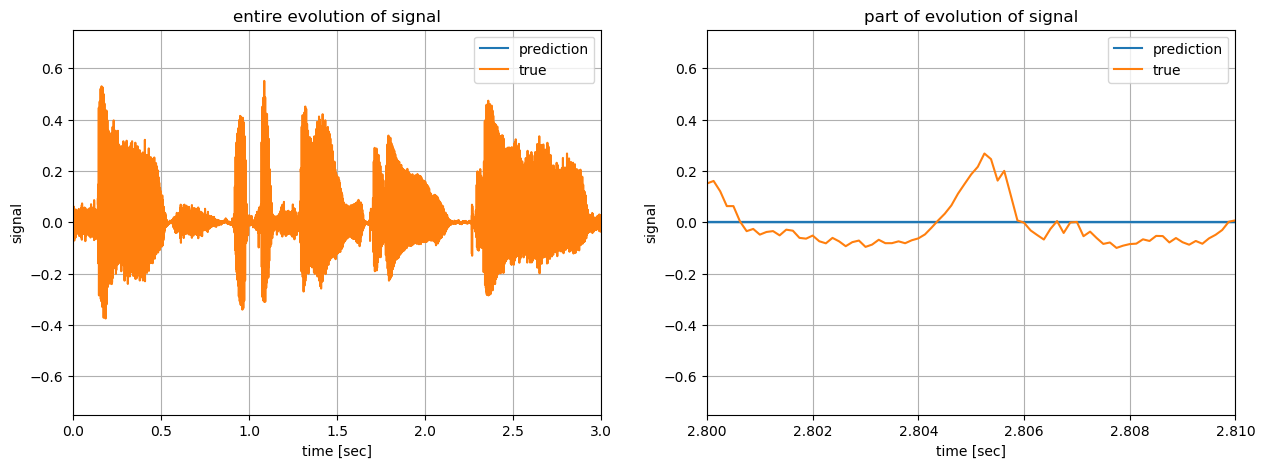

In [17]:
# create figure 
_, ax = plt.subplots(ncols=2, figsize=(15,5))

# plot prediction of frequency component
ax[1].plot(t, μ_x_pred, label="prediction"), ax[2].plot(t, μ_x_pred, label="prediction")
ax[2].fill_between(t, μ_x_pred .- sqrt.(var_x_pred), μ_x_pred .+ sqrt.(var_x_pred), alpha=0.3)

# plot true evolution of frequency component # add offset because prediction is only performed for second sample forwards
ax[1].plot(t, x_time, label="true"), ax[2].plot(t, x_time, label="true") 

# change visualization
ax[1].legend(), ax[1].grid(), ax[1].set_xlabel("time [sec]"), ax[1].set_ylabel("signal"), ax[1].set_title("entire evolution of signal"), ax[1].set_xlim(0, 3)
ax[2].legend(), ax[2].grid(), ax[2].set_xlabel("time [sec]"), ax[2].set_ylabel("signal"), ax[2].set_title("part of evolution of signal")
ax[2].set_xlim(2.8, 2.81), ax[2].set_ylim(-0.75,0.75), ax[1].set_ylim(-0.75, 0.75)

audioplayers(x_time, μ_x_pred, fs=fs_desired)
;

## Visualize parameters

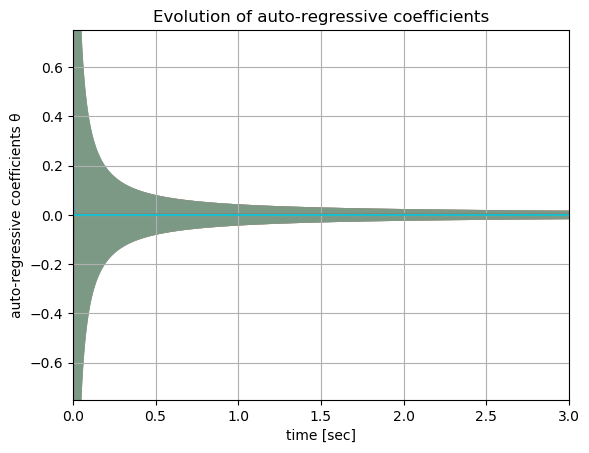

In [16]:
# loop through auto-regressive coefficients
for ki = 1:AR_order
    
    # plot auto-regressive coefficients
    plt.plot(t, [μ_θ_mem[k][ki] for k=1:length(μ_θ_mem)])
    
    plt.fill_between(t, [μ_θ_mem[k][ki] for k=1:length(μ_θ_mem)] .- sqrt.([1/Λ_θ_mem[k][ki,ki] for k=1:length(μ_θ_mem)]), [μ_θ_mem[k][ki] for k=1:length(μ_θ_mem)] .+ sqrt.([1/Λ_θ_mem[k][ki,ki] for k=1:length(μ_θ_mem)]), alpha=0.3)
    
end

# change visualization
plt.grid(), plt.ylim(-0.75, 0.75), plt.xlim(0, 3), plt.xlabel("time [sec]"), plt.ylabel("auto-regressive coefficients θ"), plt.title("Evolution of auto-regressive coefficients")
;

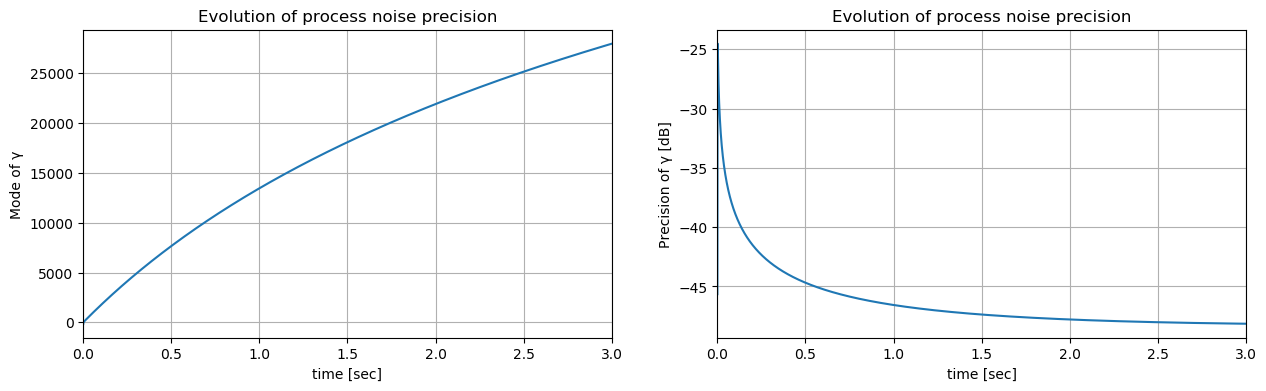

In [11]:
_, ax = plt.subplots(ncols=2, figsize=(15,4))
ax[1].plot(t, [(a_γ_mem[k]-1)/b_γ_mem[k] for k = 1:length(a_γ_mem)])
ax[2].plot(t, [10*log10.(b_γ_mem[k]^2/a_γ_mem[k]) for k = 1:length(a_γ_mem)])

# change visualization
ax[1].grid(), ax[1].set_xlim(0, 3), ax[1].set_xlabel("time [sec]"), ax[1].set_ylabel("Mode of γ"), ax[1].set_title("Evolution of process noise precision")
ax[2].grid(), ax[2].set_xlim(0, 3), ax[2].set_xlabel("time [sec]"), ax[2].set_ylabel("Precision of γ [dB]"), ax[2].set_title("Evolution of process noise precision")
;

## Plot final spectral estimate

In [12]:
using Distributions
include("visualization.jl")
;

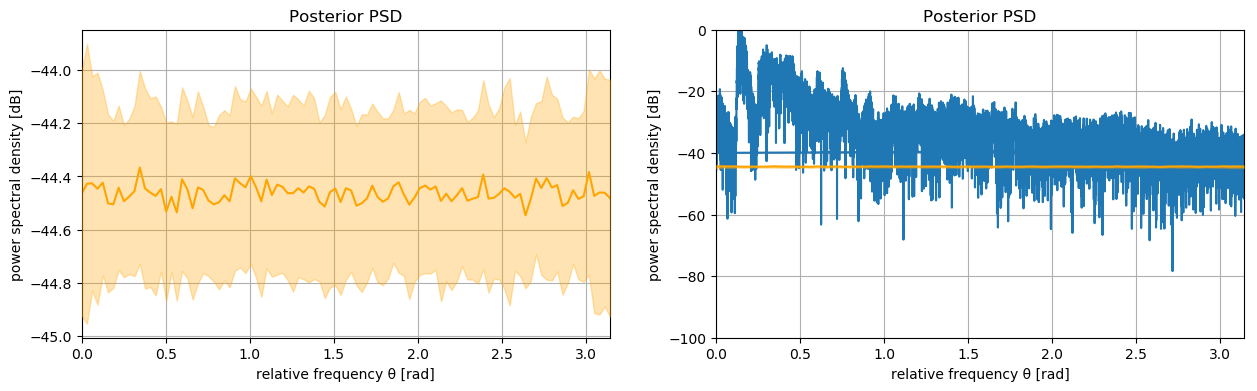

In [13]:
μ_θ_cur = μ_θ_mem[end]
Λ_θ_cur = Λ_θ_mem[end]
a_γ_cur = a_γ_mem[end]
b_γ_cur = b_γ_mem[end]

θ, γ = AR_distributions(μ_θ_cur, Λ_θ_cur, a_γ_cur, b_γ_cur)
mean_psd, std_psd = summary_psd(θ, γ)

_, ax = plt.subplots(ncols=2, figsize=(15,4))
ax[2].plot(FFTW.fftfreq(length(x_time), fs_desired)/fs_desired*2*pi, 10*log10.((abs.(FFTW.fft(x_time)).^2)./length(x_time)))
plot_psd(ax[1], mean_psd, std_psd)
plot_psd(ax[2], mean_psd, std_psd)

ax[1].grid(), ax[1].set_xlabel("relative frequency θ [rad]"), ax[1].set_ylabel("power spectral density [dB]"), ax[1].set_title("Posterior PSD"), ax[1].set_xlim(0, pi)
ax[2].grid(), ax[2].set_xlabel("relative frequency θ [rad]"), ax[2].set_ylabel("power spectral density [dB]"), ax[2].set_title("Posterior PSD"), ax[2].set_xlim(0, pi), ax[2].set_ylim(-100,0)
;